In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

In [4]:
columns = [
    'white_king_file', 'white_king_rank',
    'white_rook_file', 'white_rook_rank',
    'black_king_file', 'black_king_rank',
    'depth']

df = pd.read_csv('krkopt.data', header=None, names=columns)

mapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8}
for col in ['white_king_file', 'white_rook_file', 'black_king_file']:
    df[col] = df[col].map(mapping)

depth_map = {
    'draw': -1, 'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
    'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
    'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14,
    'fifteen': 15, 'sixteen': 16}

df['depth'] = df['depth'].map(depth_map)

In [5]:
### funkcja do pytanie 1

def draw_king_heatmap(positions, title):

    heatmap_matrix = np.zeros((8, 8))

    counts = positions.groupby(['black_king_rank', 'black_king_file']).size()
    for (rank, file), count in counts.items():
        heatmap_matrix[8-rank, file-1] = count

    plt.figure(figsize=(10, 7))
    sns.heatmap(heatmap_matrix, annot=True, cmap="Greens",
                xticklabels=['a','b','c','d','e','f','g','h'],
                yticklabels=['8','7','6','5','4','3','2','1'])
    plt.title(title, fontsize=15)
    plt.xlabel('Kolumna (File)')
    plt.ylabel('Wiersz (Rank)')
    plt.show()

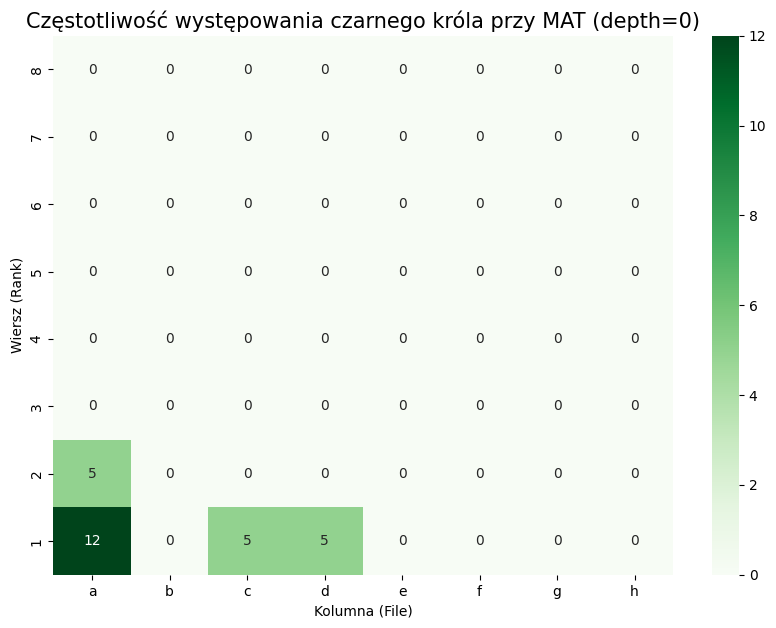

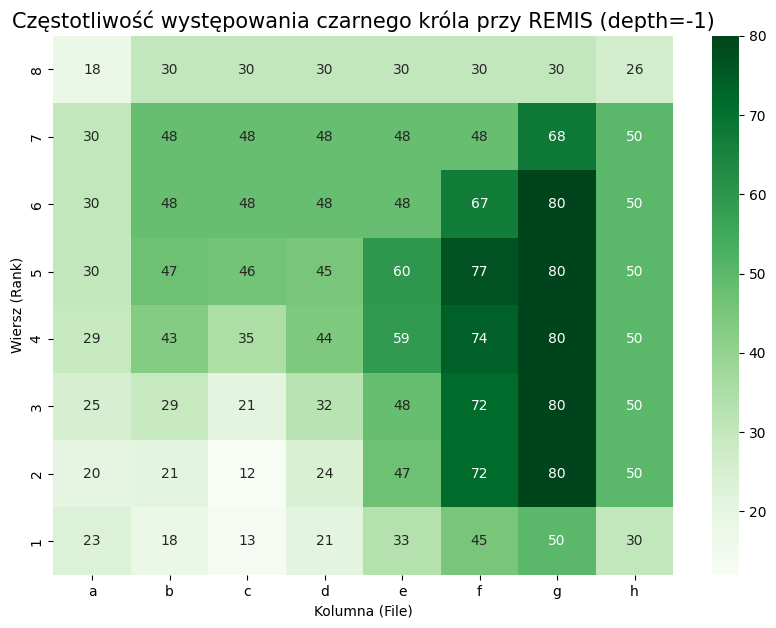

In [6]:
### wykresy do pytanie 1

# pozycje przy macie
mat_positions = df[df['depth'] == 0]
draw_king_heatmap(mat_positions, "Częstotliwość występowania czarnego króla przy MAT (depth=0)")

# pozycje przy remisie
draw_positions = df[df['depth'] == -1]
draw_king_heatmap(draw_positions, "Częstotliwość występowania czarnego króla przy REMIS (depth=-1)")

Mat (depth=0): Według analizy matowanie czarnego króla (gdy białe mają tylko króla i wieżę) jest możliwe wyłącznie na krawędziach lub w rogach planszy. Nasza analiza danych to potwierdza: wszystkie 27 przypadków matu w zbiorze danych występują, gdy czarny król znajduje się w narożniku (np. pole a1 lub a8) lub na krawędzi planszy. Na środku planszy liczba matów wynosi 0.

Remis (depth=-1): Sytuacje remisowe są znacznie częstsze (2796 przypadków). Na wykresie widać, że remisy są bardziej rozproszone niż maty, ale często koncentrują się w specyficznych rejonach (np. pola przyległe do pól brzegowych)

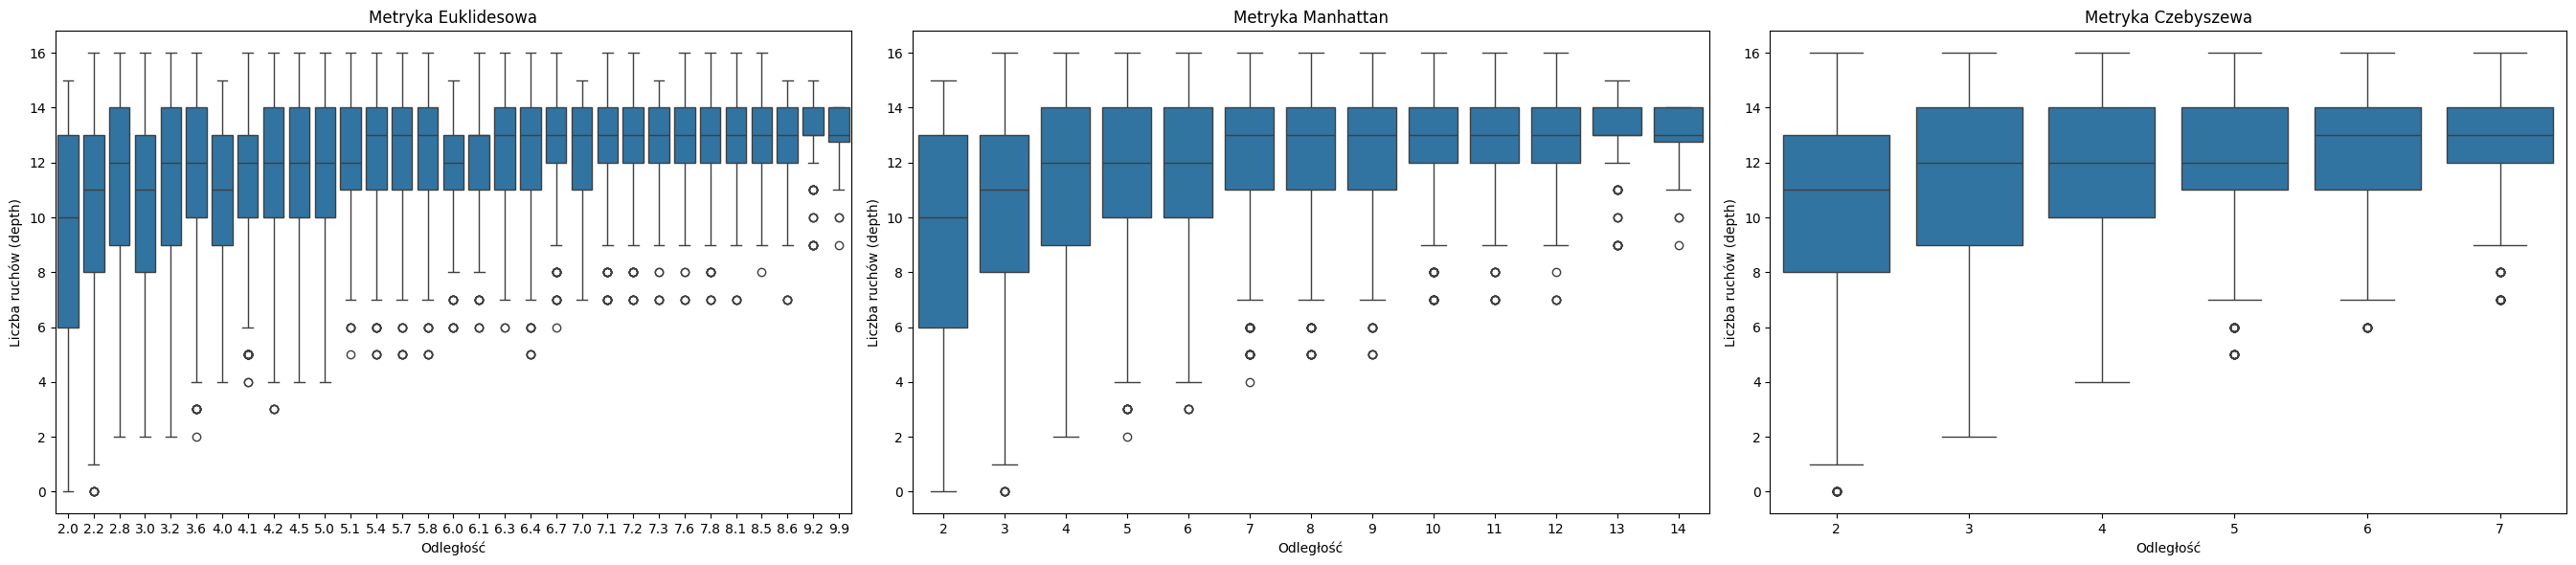

Korelacja Pearsona dla dist_euclidean: 0.291
Korelacja Pearsona dla dist_manhattan: 0.297
Korelacja Pearsona dla dist_chebyshev: 0.266


In [ ]:
### pytanie 2

df_win = df[df['depth'] > -1].copy()

### odległości w trzech metrykach
df_win['dist_euclidean'] = np.sqrt((df_win['white_king_file'] - df_win['black_king_file'])**2 +
                                   (df_win['white_king_rank'] - df_win['black_king_rank'])**2).round(1)

df_win['dist_manhattan'] = (abs(df_win['white_king_file'] - df_win['black_king_file']) +
                           abs(df_win['white_king_rank'] - df_win['black_king_rank']))

df_win['dist_czybyszew'] = np.maximum(abs(df_win['white_king_file'] - df_win['black_king_file']),
                                      abs(df_win['white_king_rank'] - df_win['black_king_rank']))


metrics = ['dist_euclidean', 'dist_manhattan', 'dist_czybyszew']
titles = ['Metryka Euklidesowa', 'Metryka Manhattan', 'Metryka Czebyszewa']

plt.figure(figsize=(27, 6))
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=metric, y='depth', data=df_win)
    plt.title(titles[i])
    plt.xlabel('Odległość')
    plt.ylabel('Liczba ruchów (depth)')

plt.tight_layout()
plt.show()

for metric in metrics:
    corr, _ = stats.pearsonr(df_win[metric], df_win['depth'])
    print(f"Korelacja Pearsona dla {metric}: {corr.round(3)}")

Choć król porusza się zgodnie z metryką Czebyszewa (może bić na ukos), to metryka Manhattan okazała się najlepszym przybliżeniem liczby ruchów.
Widzimy jednak, że wszystkie 3 metryki odległości między królami wykazują słabą korelację dodatnią, co oznacza, że dystans między figurami jest tylko jednym z wielu czynników wpływających na długość partii.

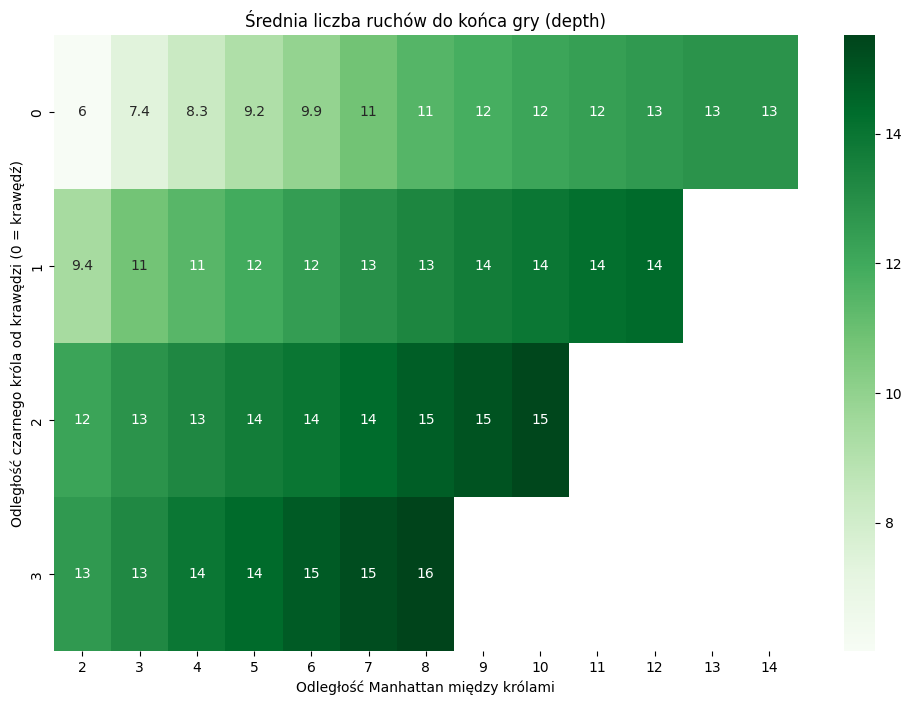

In [ ]:
### pytanie 3

df_win['dist_edge'] = df_win[['black_king_file', 'black_king_rank']].apply(
    lambda row: min(row['black_king_file'] - 1, 8 - row['black_king_file'],
                    row['black_king_rank'] - 1, 8 - row['black_king_rank']), axis=1)

# uzywam manhattan bo wyszlo nalepiej w poprzedniej analizie
df_win['dist_kings'] = abs(df_win['white_king_file'] - df_win['black_king_file']) + \
                       abs(df_win['white_king_rank'] - df_win['black_king_rank'])

## tabela przestawna
pivot_table = df_win.pivot_table(values='depth', index='dist_edge', columns='dist_kings', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap="Greens")
plt.title('Średnia liczba ruchów do końca gry')
plt.xlabel('Odległość Manhattan między królami')
plt.ylabel('Odległość czarnego króla od krawędzi')
plt.show()


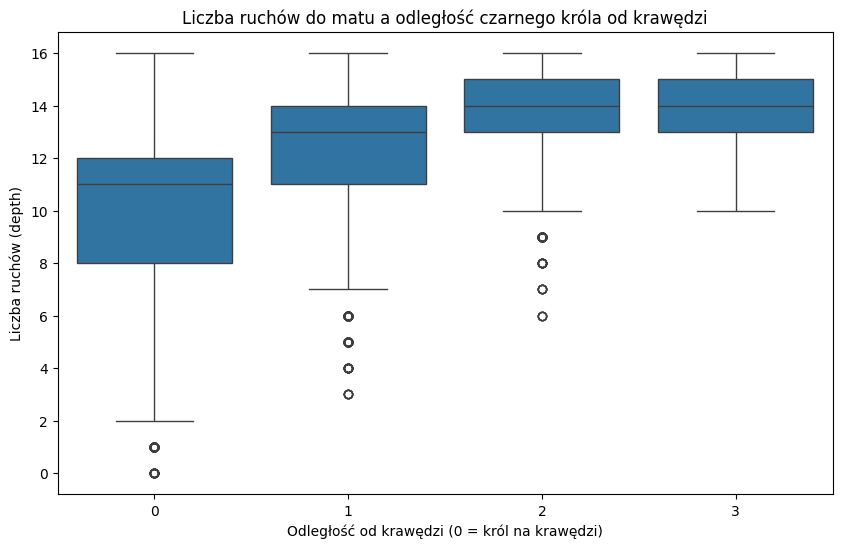

Korelacja (odległość od krawędzi): 0.508


In [ ]:
### pytanie 3

df_win['dist_edge'] = df_win[['black_king_file', 'black_king_rank']].apply(
    lambda row: min(row['black_king_file'] - 1, 8 - row['black_king_file'],
                    row['black_king_rank'] - 1, 8 - row['black_king_rank']), axis=1)

plt.figure(figsize=(10, 6))
sns.boxplot(x='dist_edge', y='depth', data=df_win)
plt.title("Liczba ruchów do matu a odległość czarnego króla od krawędzi")
plt.xlabel("Odległość od krawędzi")
plt.ylabel("Liczba ruchów")
plt.show()

print(f"Korelacja (odległość od krawędzi): {df_win['dist_edge'].corr(df_win['depth']):.3f}")

In [ ]:
### pytanie 3

X = df_win[['dist_edge', 'dist_manhattan']]
y = df_win['depth']

model = LinearRegression()
model.fit(X, y)

r_sq = model.score(X, y)
corr_mix = np.sqrt(r_sq)

print(f"Korelacja połączona: {round(corr_mix, 3)}")
print(f"Współczynnik determinacji: {round(r_sq, 3)}")

Korelacja połączona: 0.69
Współczynnik determinacji (R^2): 0.477


Przeprowadzona analiza wykazała, że odległość od krawędzi jest najsilniejszym pojedynczym wskaźnikiem trudności pozycji. Współczynnik korelacji Pearsona dla tej cechy wynosi 0,508, co wskazuje na wyraźny związek dodatni: im dalej od krawędzi znajduje się czarny król, tym więcej ruchów potrzeba, aby zakończyć grę.

Czy uzupełnienie tej informacji o dystans między królami pomaga? Tak, połączenie obu cech daje pełniejszy obraz sytuacji. Świadczy o tym współczynnik korelacji dla połączonych dwóch zmiennych, który po uwzględnieniu obu odległości (od krawędzi oraz pomiedzy królami w metryce Manhttan) wzrósł do poziomu 0,690.

Współczynnik determinacji  wyniósł 0,477, oznacza to, że te dwie odległości wspólnie tłumaczą prawie 50% zmienności czasu trwania gry. Jest to bardzo wysoki wynik, biorąc pod uwagę, że całkowicie zignorowaliśmy pozycję wieży.